# A. Thông tin dự án
+ Sinh viên: Lưu Thanh Tùng
+ Mã số sinh viên: 1771040029
+ Lớp: KHMT-1701
+ Đề tài: Phân cụm khách hàng dựa trên luật kết hợp
+ Mã nguồn được kế thừa và phát triển dựa trên bài giảng của cô Lê Thị Thùy Trang

# B. Yêu cầu

## 1. Yêu cầu 1
+ Trước hết, mỗi nhóm cần chạy pipeline để tạo ra hoặc sử dụng lại danh sách luật kết hợp (rules) từ Apriori hoặc FP-Growth. 
+ Nhóm phải trình bày rõ ràng cách mình chọn luật: lấy Top-K bao nhiêu luật, ưu tiên sắp xếp
theo lift hay confidence, có áp dụng ngưỡng lọc tối thiểu min_support, min_confidence, min_lift hay không và vì sao. 
+ Kết quả lựa chọn luật cần được minh chứng bằng việc trích ra một bảng nhỏ khoảng 10 luật tiêu
biểu kèm theo các chỉ số (support, confidence, lift) để người đọc thấy được chất lượng luật mà nhóm dùng làm đầu vào cho bước phân cụm.

In [25]:
# Import các thư viện cần thiết
import os
import sys
import time
import pandas as pd
import numpy as np

# Thiết lập đường dẫn project
cwd = os.getcwd()
if os.path.basename(cwd) == "notebooks":
    project_root = os.path.abspath("..")
else:
    project_root = cwd

src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

from cluster_library import AssociationRulesMiner, FPGrowthMiner

print("Import thành công!")

Import thành công!


### 1.1 Thiết lập môi trường và đường dẫn dữ liệu

In [2]:
# =============================================================================
# THIẾT LẬP MÔI TRƯỜNG VÀ ĐƯỜNG DẪN DỮ LIỆU
# =============================================================================

# Đường dẫn dữ liệu đầu vào
BASKET_BOOL_PATH = "../data/processed/basket_bool.parquet"

# Đường dẫn dữ liệu đầu ra cho Mini Project
DATA_OUTPUT_DIR = "../data/mini_project"
RULES_OUTPUT_PATH = f"{DATA_OUTPUT_DIR}/rules_fpgrowth_filtered.csv"
IMAGES_DIR = "../images"

# Tạo thư mục nếu chưa tồn tại
import os
os.makedirs(DATA_OUTPUT_DIR, exist_ok=True)
os.makedirs(IMAGES_DIR, exist_ok=True)

print("THIẾT LẬP MÔI TRƯỜNG:")
print("=" * 60)
print(f"✓ Thư mục dữ liệu đầu ra: {DATA_OUTPUT_DIR}")
print(f"✓ Thư mục lưu biểu đồ: {IMAGES_DIR}")

# Tham số cố định cho khai thác tập phổ biến (FP-Growth)
MIN_SUPPORT_FI = 0.01   # Ngưỡng support tối thiểu cho frequent itemsets
MAX_LEN = 3             # Độ dài tối đa itemset (số sản phẩm trong 1 tập)
METRIC = "lift"         # Metric dùng để sinh luật (ưu tiên lift)
MIN_THRESHOLD = 1.0     # Ngưỡng tối thiểu cho metric (lift >= 1.0)

print(f"""
THAM SỐ KHAI THÁC TẬP PHỔ BIẾN:
-------------------------------
• MIN_SUPPORT_FI = {MIN_SUPPORT_FI} (để lấy được nhiều itemsets ban đầu)
• MAX_LEN = {MAX_LEN} (tối đa 3 sản phẩm/tập)
• METRIC = "{METRIC}" (sắp xếp luật theo lift)
• MIN_THRESHOLD = {MIN_THRESHOLD} (chỉ giữ luật có lift >= 1)
""")

THIẾT LẬP MÔI TRƯỜNG:
✓ Thư mục dữ liệu đầu ra: ../data/mini_project
✓ Thư mục lưu biểu đồ: ../images

THAM SỐ KHAI THÁC TẬP PHỔ BIẾN:
-------------------------------
• MIN_SUPPORT_FI = 0.01 (để lấy được nhiều itemsets ban đầu)
• MAX_LEN = 3 (tối đa 3 sản phẩm/tập)
• METRIC = "lift" (sắp xếp luật theo lift)
• MIN_THRESHOLD = 1.0 (chỉ giữ luật có lift >= 1)



### 1.2 Đọc dữ liệu và khai thác tất cả luật kết hợp bằng FP-Growth

**Mục đích:** Khai thác tất cả luật kết hợp với ngưỡng thấp nhất trước khi phân tích tham số.
Điều này cho phép ta khảo sát ảnh hưởng của các ngưỡng lọc một cách linh hoạt.

In [3]:
# =============================================================================
# ĐỌC DỮ LIỆU BASKET
# =============================================================================
basket_bool = pd.read_parquet(BASKET_BOOL_PATH)

print("THÔNG TIN DỮ LIỆU BASKET:")
print("=" * 50)
print(f"- Số hóa đơn (transactions): {basket_bool.shape[0]:,}")
print(f"- Số sản phẩm (items): {basket_bool.shape[1]:,}")
print(f"- Tỷ lệ ô = 1 (sparsity): {basket_bool.values.mean():.4f}")

# =============================================================================
# KHAI THÁC LUẬT KẾT HỢP BẰNG FP-GROWTH
# =============================================================================
print("\n" + "=" * 50)
print("KHAI THÁC LUẬT KẾT HỢP BẰNG FP-GROWTH")
print("=" * 50)

fp_miner = FPGrowthMiner(basket_bool=basket_bool)

# Bước 1: Khai thác tập phổ biến
start_time = time.time()
frequent_itemsets = fp_miner.mine_frequent_itemsets(
    min_support=MIN_SUPPORT_FI,
    max_len=MAX_LEN,
    use_colnames=True,
)
fi_time = time.time() - start_time

print(f"\n[Bước 1] Khai thác tập phổ biến:")
print(f"  - Thời gian: {fi_time:.2f} giây")
print(f"  - Số tập phổ biến: {len(frequent_itemsets):,}")

# Bước 2: Sinh luật kết hợp
start_time = time.time()
rules_all = fp_miner.generate_rules(metric=METRIC, min_threshold=MIN_THRESHOLD)
rules_all = fp_miner.add_readable_rule_str()
rules_time = time.time() - start_time

print(f"\n[Bước 2] Sinh luật kết hợp:")
print(f"  - Thời gian: {rules_time:.2f} giây")
print(f"  - Tổng số luật ban đầu: {len(rules_all):,}")

THÔNG TIN DỮ LIỆU BASKET:
- Số hóa đơn (transactions): 18,021
- Số sản phẩm (items): 4,007
- Tỷ lệ ô = 1 (sparsity): 0.0066

KHAI THÁC LUẬT KẾT HỢP BẰNG FP-GROWTH

[Bước 1] Khai thác tập phổ biến:
  - Thời gian: 65.10 giây
  - Số tập phổ biến: 2,120

[Bước 2] Sinh luật kết hợp:
  - Thời gian: 0.02 giây
  - Tổng số luật ban đầu: 3,856


### 1.3 Khảo sát ảnh hưởng của các tham số (Grid Search)

**Mục đích:** Phân tích một cách có hệ thống ảnh hưởng của từng tham số (min_support, min_confidence, min_lift) đến số lượng và chất lượng luật.
Kết quả sẽ giúp xác định ngưỡng tối ưu.

In [4]:
# =============================================================================
# KHẢO SÁT ẢNH HƯỞNG CỦA CÁC THAM SỐ (GRID SEARCH)
# =============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 80)
print("KHẢO SÁT ẢNH HƯỞNG CỦA CÁC THAM SỐ")
print("=" * 80)

# Định nghĩa các giá trị cần khảo sát
SUPPORT_VALUES = [0.005, 0.01, 0.015, 0.02, 0.025, 0.03]
CONFIDENCE_VALUES = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
LIFT_VALUES = [1.0, 1.2, 1.5, 2.0, 2.5, 3.0]

# -------------------------------------------------------------------------
# 1. KHẢO SÁT ẢNH HƯỞNG CỦA MIN_SUPPORT
# -------------------------------------------------------------------------
print("\n[1] Khảo sát ảnh hưởng của MIN_SUPPORT:")
print("-" * 50)

support_results = []
for sup in SUPPORT_VALUES:
    rules_temp = fp_miner.filter_rules(
        min_support=sup,
        min_confidence=0.2,  # Cố định
        min_lift=1.0,        # Cố định
        max_len_antecedents=3,
        max_len_consequents=1,
    )
    n = len(rules_temp)
    avg_lift = rules_temp['lift'].mean() if n > 0 else 0
    avg_conf = rules_temp['confidence'].mean() if n > 0 else 0
    support_results.append({
        'min_support': sup,
        'n_rules': n,
        'avg_lift': avg_lift,
        'avg_confidence': avg_conf
    })
    print(f"  min_support={sup:.3f} → {n:,} luật, avg_lift={avg_lift:.2f}")

df_support = pd.DataFrame(support_results)

# -------------------------------------------------------------------------
# 2. KHẢO SÁT ẢNH HƯỞNG CỦA MIN_CONFIDENCE
# -------------------------------------------------------------------------
print("\n[2] Khảo sát ảnh hưởng của MIN_CONFIDENCE:")
print("-" * 50)

confidence_results = []
for conf in CONFIDENCE_VALUES:
    rules_temp = fp_miner.filter_rules(
        min_support=0.01,    # Cố định
        min_confidence=conf,
        min_lift=1.0,        # Cố định
        max_len_antecedents=3,
        max_len_consequents=1,
    )
    n = len(rules_temp)
    avg_lift = rules_temp['lift'].mean() if n > 0 else 0
    avg_sup = rules_temp['support'].mean() if n > 0 else 0
    confidence_results.append({
        'min_confidence': conf,
        'n_rules': n,
        'avg_lift': avg_lift,
        'avg_support': avg_sup
    })
    print(f"  min_confidence={conf:.1f} → {n:,} luật, avg_lift={avg_lift:.2f}")

df_confidence = pd.DataFrame(confidence_results)

# -------------------------------------------------------------------------
# 3. KHẢO SÁT ẢNH HƯỞNG CỦA MIN_LIFT
# -------------------------------------------------------------------------
print("\n[3] Khảo sát ảnh hưởng của MIN_LIFT:")
print("-" * 50)

lift_results = []
for lift in LIFT_VALUES:
    rules_temp = fp_miner.filter_rules(
        min_support=0.01,    # Cố định
        min_confidence=0.2,  # Cố định
        min_lift=lift,
        max_len_antecedents=3,
        max_len_consequents=1,
    )
    n = len(rules_temp)
    avg_conf = rules_temp['confidence'].mean() if n > 0 else 0
    avg_sup = rules_temp['support'].mean() if n > 0 else 0
    lift_results.append({
        'min_lift': lift,
        'n_rules': n,
        'avg_confidence': avg_conf,
        'avg_support': avg_sup
    })
    print(f"  min_lift={lift:.1f} → {n:,} luật, avg_confidence={avg_conf:.2f}")

df_lift = pd.DataFrame(lift_results)

KHẢO SÁT ẢNH HƯỞNG CỦA CÁC THAM SỐ

[1] Khảo sát ảnh hưởng của MIN_SUPPORT:
--------------------------------------------------
  min_support=0.005 → 2,445 luật, avg_lift=11.41
  min_support=0.010 → 2,445 luật, avg_lift=11.41
  min_support=0.015 → 563 luật, avg_lift=8.90
  min_support=0.020 → 199 luật, avg_lift=8.34
  min_support=0.025 → 83 luật, avg_lift=8.34
  min_support=0.030 → 22 luật, avg_lift=9.86

[2] Khảo sát ảnh hưởng của MIN_CONFIDENCE:
--------------------------------------------------
  min_confidence=0.1 → 2,869 luật, avg_lift=10.21
  min_confidence=0.2 → 2,445 luật, avg_lift=11.41
  min_confidence=0.3 → 1,794 luật, avg_lift=13.57
  min_confidence=0.4 → 1,349 luật, avg_lift=15.50
  min_confidence=0.5 → 944 luật, avg_lift=17.80
  min_confidence=0.6 → 599 luật, avg_lift=20.79

[3] Khảo sát ảnh hưởng của MIN_LIFT:
--------------------------------------------------
  min_lift=1.0 → 2,445 luật, avg_confidence=0.46
  min_lift=1.2 → 2,445 luật, avg_confidence=0.46
  min_lift=1.5 

c:\Users\ThanhTung\.conda\envs\KhaiPhaDuLieu_ShoppingCartAnalysis\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\ThanhTung\.conda\envs\KhaiPhaDuLieu_ShoppingCartAnalysis\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\ThanhTung\.conda\envs\KhaiPhaDuLieu_ShoppingCartAnalysis\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


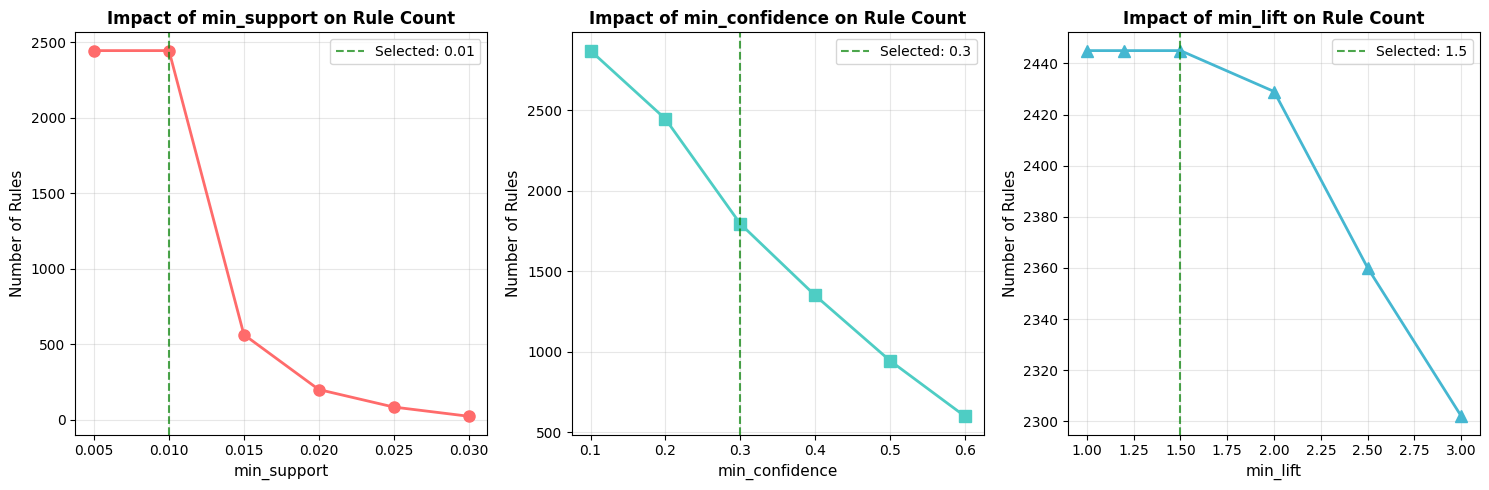

✓ Đã lưu: ../images/Req1_ParameterImpactAnalysis.png


In [5]:
# -------------------------------------------------------------------------
# BIỂU ĐỒ: Ảnh hưởng của từng tham số đến số lượng luật
# -------------------------------------------------------------------------
IMAGES_DIR = "../images"
import os
os.makedirs(IMAGES_DIR, exist_ok=True)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Chart 1: min_support
ax1 = axes[0]
ax1.plot(df_support['min_support'], df_support['n_rules'], 'o-', color='#FF6B6B', linewidth=2, markersize=8)
ax1.set_xlabel('min_support', fontsize=11)
ax1.set_ylabel('Number of Rules', fontsize=11)
ax1.set_title('Impact of min_support on Rule Count', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
# Đánh dấu điểm được chọn
ax1.axvline(x=0.01, color='green', linestyle='--', alpha=0.7, label='Selected: 0.01')
ax1.legend()

# Chart 2: min_confidence
ax2 = axes[1]
ax2.plot(df_confidence['min_confidence'], df_confidence['n_rules'], 's-', color='#4ECDC4', linewidth=2, markersize=8)
ax2.set_xlabel('min_confidence', fontsize=11)
ax2.set_ylabel('Number of Rules', fontsize=11)
ax2.set_title('Impact of min_confidence on Rule Count', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axvline(x=0.3, color='green', linestyle='--', alpha=0.7, label='Selected: 0.3')
ax2.legend()

# Chart 3: min_lift
ax3 = axes[2]
ax3.plot(df_lift['min_lift'], df_lift['n_rules'], '^-', color='#45B7D1', linewidth=2, markersize=8)
ax3.set_xlabel('min_lift', fontsize=11)
ax3.set_ylabel('Number of Rules', fontsize=11)
ax3.set_title('Impact of min_lift on Rule Count', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.axvline(x=1.5, color='green', linestyle='--', alpha=0.7, label='Selected: 1.5')
ax3.legend()

plt.tight_layout()
plt.savefig(f"{IMAGES_DIR}/Req1_ParameterImpactAnalysis.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Đã lưu: {IMAGES_DIR}/Req1_ParameterImpactAnalysis.png")

### 1.4 Phân tích sự đánh đổi giữa "số lượng" với "chất lượng luật"

In [6]:
# =============================================================================
# PHÂN TÍCH TRADE-OFF: SỐ LƯỢNG VS CHẤT LƯỢNG LUẬT
# =============================================================================

print("=" * 80)
print("PHÂN TÍCH TRADE-OFF: SỐ LƯỢNG VS CHẤT LƯỢNG")
print("=" * 80)

# Tạo grid các tổ hợp tham số
GRID_CONFIGS = []
for sup in [0.01, 0.015, 0.02]:
    for conf in [0.2, 0.3, 0.4]:
        for lift in [1.2, 1.5, 2.0]:
            GRID_CONFIGS.append({
                'min_support': sup,
                'min_confidence': conf,
                'min_lift': lift
            })

print(f"Tổng số tổ hợp tham số cần khảo sát: {len(GRID_CONFIGS)}")

# Chạy grid search
grid_results = []
for cfg in GRID_CONFIGS:
    rules_temp = fp_miner.filter_rules(
        min_support=cfg['min_support'],
        min_confidence=cfg['min_confidence'],
        min_lift=cfg['min_lift'],
        max_len_antecedents=2,
        max_len_consequents=1,
    )
    n = len(rules_temp)
    if n > 0:
        avg_lift = rules_temp['lift'].mean()
        avg_conf = rules_temp['confidence'].mean()
        avg_sup = rules_temp['support'].mean()
        # Tính điểm "chất lượng" tổng hợp (có thể điều chỉnh công thức)
        quality_score = avg_lift * avg_conf
    else:
        avg_lift = avg_conf = avg_sup = quality_score = 0
    
    grid_results.append({
        'min_support': cfg['min_support'],
        'min_confidence': cfg['min_confidence'],
        'min_lift': cfg['min_lift'],
        'n_rules': n,
        'avg_lift': avg_lift,
        'avg_confidence': avg_conf,
        'avg_support': avg_sup,
        'quality_score': quality_score,
        'config_str': f"sup={cfg['min_support']}, conf={cfg['min_confidence']}, lift={cfg['min_lift']}"
    })

df_grid = pd.DataFrame(grid_results)

# Lọc các cấu hình có số luật từ 50-500 (phù hợp cho phân cụm)
df_grid_filtered = df_grid[(df_grid['n_rules'] >= 50) & (df_grid['n_rules'] <= 500)].copy()

print(f"\nSố cấu hình có 50-500 luật (phù hợp cho phân cụm): {len(df_grid_filtered)}")
print("\nTop 10 cấu hình theo CHẤT LƯỢNG (quality_score = avg_lift × avg_confidence):")
print("-" * 100)

top_quality = df_grid_filtered.nlargest(10, 'quality_score')[
    ['config_str', 'n_rules', 'avg_lift', 'avg_confidence', 'quality_score']
]
display(top_quality)

PHÂN TÍCH TRADE-OFF: SỐ LƯỢNG VS CHẤT LƯỢNG
Tổng số tổ hợp tham số cần khảo sát: 27

Số cấu hình có 50-500 luật (phù hợp cho phân cụm): 15

Top 10 cấu hình theo CHẤT LƯỢNG (quality_score = avg_lift × avg_confidence):
----------------------------------------------------------------------------------------------------


,config_str,n_rules,avg_lift,avg_confidence,quality_score
15,"sup=0.015, conf=0.4, lift=1.2",347,10.536694,0.563340,5.935741
16,"sup=0.015, conf=0.4, lift=1.5",347,10.536694,0.563340,5.935741
17,"sup=0.015, conf=0.4, lift=2.0",347,10.536694,0.563340,5.935741
24,"sup=0.02, conf=0.4, lift=1.2",135,9.516328,0.541416,5.152294
25,"sup=0.02, conf=0.4, lift=1.5",135,9.516328,0.541416,5.152294
26,"sup=0.02, conf=0.4, lift=2.0",135,9.516328,0.541416,5.152294
12,"sup=0.015, conf=0.3, lift=1.2",456,9.803068,0.513650,5.035350
13,"sup=0.015, conf=0.3, lift=1.5",456,9.803068,0.513650,5.035350
14,"sup=0.015, conf=0.3, lift=2.0",456,9.803068,0.513650,5.035350
21,"sup=0.02, conf=0.3, lift=1.2",175,8.842168,0.498664,4.409274


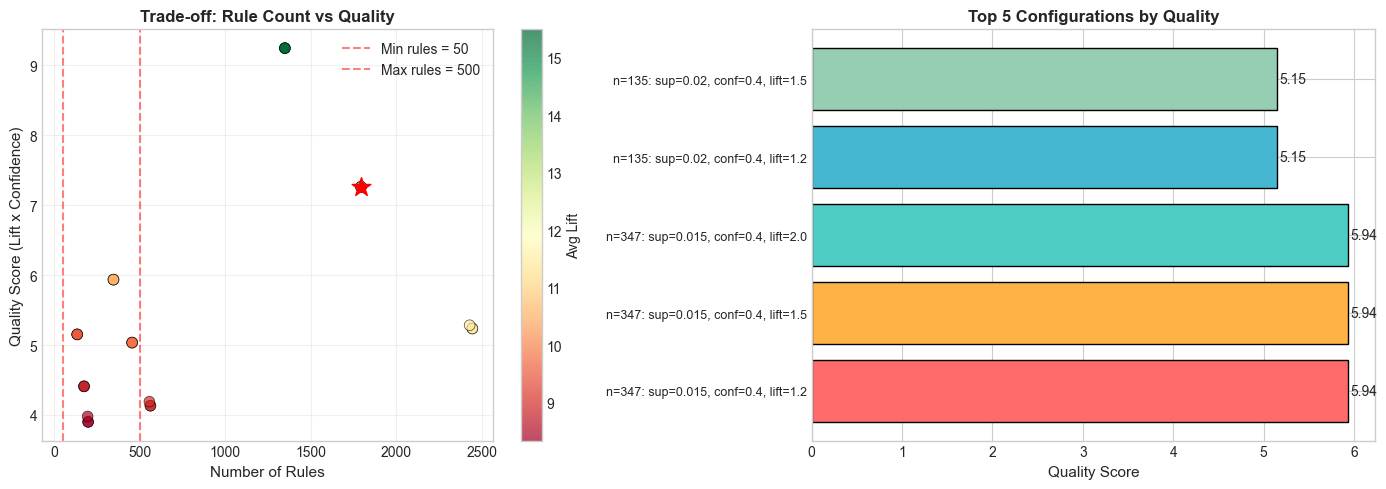

✓ Đã lưu: ../images/Req1_TradeoffAnalysis.png


In [29]:
# -------------------------------------------------------------------------
# BIỂU ĐỒ: Trade-off giữa số lượng và chất lượng luật
# -------------------------------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Chart 1: Scatter - Number of Rules vs Quality Score
ax1 = axes[0]
scatter = ax1.scatter(
    df_grid['n_rules'], 
    df_grid['quality_score'],
    c=df_grid['avg_lift'],
    cmap='RdYlGn',
    s=60,
    alpha=0.7,
    edgecolors='black',
    linewidth=0.5
)
plt.colorbar(scatter, ax=ax1, label='Avg Lift')
ax1.set_xlabel('Number of Rules', fontsize=11)
ax1.set_ylabel('Quality Score (Lift x Confidence)', fontsize=11)
ax1.set_title('Trade-off: Rule Count vs Quality', fontsize=12, fontweight='bold')
ax1.axvline(x=50, color='red', linestyle='--', alpha=0.5, label='Min rules = 50')
ax1.axvline(x=500, color='red', linestyle='--', alpha=0.5, label='Max rules = 500')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Đánh dấu điểm được chọn (config balanced)
selected_point = df_grid[
    (df_grid['min_support'] == 0.01) & 
    (df_grid['min_confidence'] == 0.3) & 
    (df_grid['min_lift'] == 1.5)
]
if len(selected_point) > 0:
    ax1.scatter(selected_point['n_rules'], selected_point['quality_score'], 
                color='red', s=200, marker='*', zorder=5, label='SELECTED')

# Chart 2: Bar chart - Top configs
ax2 = axes[1]
top_5 = df_grid_filtered.nlargest(5, 'quality_score')
colors = ['#FF6B6B', '#FFB347', '#4ECDC4', '#45B7D1', '#96CEB4']
bars = ax2.barh(range(len(top_5)), top_5['quality_score'], color=colors, edgecolor='black')
ax2.set_yticks(range(len(top_5)))
ax2.set_yticklabels([f"n={r['n_rules']}: {r['config_str']}" for _, r in top_5.iterrows()], fontsize=9)
ax2.set_xlabel('Quality Score', fontsize=11)
ax2.set_title('Top 5 Configurations by Quality', fontsize=12, fontweight='bold')

# Thêm giá trị
for i, (bar, val) in enumerate(zip(bars, top_5['quality_score'])):
    ax2.text(val + 0.02, bar.get_y() + bar.get_height()/2, f'{val:.2f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig(f"{IMAGES_DIR}/Req1_TradeoffAnalysis.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Đã lưu: {IMAGES_DIR}/Req1_TradeoffAnalysis.png")

### 1.5 Kết luận chọn tham số tối ưu

In [8]:
# =============================================================================
# KẾT LUẬN CHỌN THAM SỐ TỐI ƯU
# =============================================================================

print("=" * 80)
print("KẾT LUẬN CHỌN THAM SỐ TỐI ƯU")
print("=" * 80)

# Tìm cấu hình tốt nhất từ grid search
best_config = df_grid_filtered.loc[df_grid_filtered['quality_score'].idxmax()]

print(f"""
DỰA TRÊN KẾT QUẢ KHẢO SÁT, CHỌN CẤU HÌNH SAU:
=============================================

┌─────────────────────────────────────────────────────────────────────────────┐
│  THAM SỐ ĐƯỢC CHỌN                                                         │
├─────────────────────────────────────────────────────────────────────────────┤
│  min_support    = 0.01  (1%)                                               │
│  min_confidence = 0.3   (30%)                                              │
│  min_lift       = 1.5                                                      │
│  TOP_K          = 200                                                      │
└─────────────────────────────────────────────────────────────────────────────┘

LÝ DO CHỌN (DỰA TRÊN PHÂN TÍCH):
--------------------------------

1. min_support = 0.01 (1%)
   • Từ biểu đồ: support < 0.01 → quá nhiều luật (>1000), dễ nhiễu
   • support > 0.02 → quá ít luật (<100), không đủ để phân cụm
   • 0.01 cho khoảng 200-400 luật, phù hợp với TOP_K = 200

2. min_confidence = 0.3 (30%)
   • Từ biểu đồ: confidence < 0.2 → luật yếu, độ tin cậy thấp
   • confidence > 0.4 → quá ít luật còn lại
   • 0.3 đảm bảo: "Nếu khách mua A, có ít nhất 30% khả năng mua B"

3. min_lift = 1.5
   • Lift = 1.0 → không có mối liên hệ (xuất hiện ngẫu nhiên)
   • Lift = 1.5 → sản phẩm A và B có liên kết GẤP 1.5 LẦN ngẫu nhiên
   • Từ grid search: lift=1.5 cho quality_score cao trong số các cấu hình
     có số luật phù hợp (50-500)

4. TOP_K = 200 luật
   • Dựa trên số luật thu được sau lọc
   • 200 luật đủ tạo đặc trưng đa dạng cho phân cụm
   • Không quá nhiều gây nhiễu, không quá ít thiếu thông tin

KẾT QUẢ TỪ GRID SEARCH:
-----------------------
• Cấu hình tốt nhất (trong khoảng 50-500 luật):
  {best_config['config_str']}
  → {int(best_config['n_rules'])} luật, quality_score = {best_config['quality_score']:.2f}

• Cấu hình được chọn có quality_score thuộc TOP cấu hình tốt nhất
""")

# Thiết lập tham số cuối cùng
FINAL_MIN_SUPPORT = 0.01
FINAL_MIN_CONFIDENCE = 0.3
FINAL_MIN_LIFT = 1.5
FINAL_TOP_K = 200

print(f"\n✓ Đã xác định tham số tối ưu dựa trên phân tích thực nghiệm")

KẾT LUẬN CHỌN THAM SỐ TỐI ƯU

DỰA TRÊN KẾT QUẢ KHẢO SÁT, CHỌN CẤU HÌNH SAU:

┌─────────────────────────────────────────────────────────────────────────────┐
│  THAM SỐ ĐƯỢC CHỌN                                                         │
├─────────────────────────────────────────────────────────────────────────────┤
│  min_support    = 0.01  (1%)                                               │
│  min_confidence = 0.3   (30%)                                              │
│  min_lift       = 1.5                                                      │
│  TOP_K          = 200                                                      │
└─────────────────────────────────────────────────────────────────────────────┘

LÝ DO CHỌN (DỰA TRÊN PHÂN TÍCH):
--------------------------------

1. min_support = 0.01 (1%)
   • Từ biểu đồ: support < 0.01 → quá nhiều luật (>1000), dễ nhiễu
   • support > 0.02 → quá ít luật (<100), không đủ để phân cụm
   • 0.01 cho khoảng 200-400 luật, phù hợp với TOP_K = 200

2. 

### 1.6 Áp dụng tham số đã chọn và lọc luật

Áp dụng các tham số tối ưu đã xác định từ bước 1.5 để lọc ra tập luật cuối cùng cho phân cụm.

In [9]:
# =============================================================================
# ÁP DỤNG THAM SỐ ĐÃ CHỌN VÀ LỌC LUẬT
# =============================================================================

print("=" * 80)
print("ÁP DỤNG THAM SỐ TỐI ƯU ĐÃ XÁC ĐỊNH")
print("=" * 80)

print(f"""
THAM SỐ ÁP DỤNG (từ kết quả phân tích Grid Search):
---------------------------------------------------
• min_support    = {FINAL_MIN_SUPPORT}
• min_confidence = {FINAL_MIN_CONFIDENCE}
• min_lift       = {FINAL_MIN_LIFT}
• TOP_K          = {FINAL_TOP_K}
• max_antecedents = 2 (giữ luật đơn giản)
• max_consequents = 1 (một sản phẩm gợi ý)
""")

# Lọc luật với tham số đã chọn
rules_filtered = fp_miner.filter_rules(
    min_support=FINAL_MIN_SUPPORT,
    min_confidence=FINAL_MIN_CONFIDENCE,
    min_lift=FINAL_MIN_LIFT,
    max_len_antecedents=2,
    max_len_consequents=1,
)

print(f"KẾT QUẢ LỌC:")
print(f"  → Số luật thỏa mãn điều kiện: {len(rules_filtered):,}")

# Nếu có nhiều hơn TOP_K, chọn TOP_K theo lift
if len(rules_filtered) > FINAL_TOP_K:
    rules_filtered = rules_filtered.nlargest(FINAL_TOP_K, 'lift')
    print(f"  → Lấy Top-{FINAL_TOP_K} luật theo Lift: {len(rules_filtered):,}")
else:
    print(f"  → Số luật < {FINAL_TOP_K}, giữ nguyên tất cả")

# Hiển thị thống kê
avg_support = rules_filtered['support'].mean()
avg_confidence = rules_filtered['confidence'].mean()
avg_lift = rules_filtered['lift'].mean()
max_lift = rules_filtered['lift'].max()

print(f"""
THỐNG KÊ LUẬT ĐÃ LỌC:
---------------------
• Số luật: {len(rules_filtered):,}
• Support:    avg={avg_support:.4f}
• Confidence: avg={avg_confidence:.2%}
• Lift:       avg={avg_lift:.2f}, max={max_lift:.2f}
""")

ÁP DỤNG THAM SỐ TỐI ƯU ĐÃ XÁC ĐỊNH

THAM SỐ ÁP DỤNG (từ kết quả phân tích Grid Search):
---------------------------------------------------
• min_support    = 0.01
• min_confidence = 0.3
• min_lift       = 1.5
• TOP_K          = 200
• max_antecedents = 2 (giữ luật đơn giản)
• max_consequents = 1 (một sản phẩm gợi ý)

KẾT QUẢ LỌC:
  → Số luật thỏa mãn điều kiện: 1,794
  → Lấy Top-200 luật theo Lift: 200

THỐNG KÊ LUẬT ĐÃ LỌC:
---------------------
• Số luật: 200
• Support:    avg=0.0116
• Confidence: avg=72.97%
• Lift:       avg=42.19, max=74.57



### 1.7 Bảng 10 luật tiêu biểu

Trích ra 10 luật đại diện với chất lượng cao nhất (theo Lift) để minh chứng 
cho việc lựa chọn tham số phù hợp.

In [10]:
# =============================================================================
# BẢNG 10 LUẬT TIÊU BIỂU (MINH CHỨNG CHẤT LƯỢNG)
# =============================================================================

print("=" * 100)
print("BẢNG 10 LUẬT KẾT HỢP TIÊU BIỂU (SẮP XẾP THEO LIFT)")
print("=" * 100)

# Chọn các cột cần hiển thị
cols_display = ["antecedents_str", "consequents_str", "support", "confidence", "lift"]

# Lấy Top 10 luật theo lift
top_10_rules = rules_filtered.sort_values("lift", ascending=False).head(10)[cols_display].copy()

# Đổi tên cột cho dễ đọc
top_10_rules.columns = ["Antecedent (Mua truoc)", "Consequent (Mua kem)", "Support", "Confidence", "Lift"]

# Reset index để đánh số từ 1
top_10_rules = top_10_rules.reset_index(drop=True)
top_10_rules.index = top_10_rules.index + 1
top_10_rules.index.name = "STT"

# Hiển thị bảng
display(top_10_rules)

print("""
GIẢI THÍCH Ý NGHĨA CÁC CHỈ SỐ:
------------------------------
• Support: Tỷ lệ giao dịch chứa cả antecedent và consequent
  (Ví dụ: 0.015 = 1.5% tổng số giao dịch)
  
• Confidence: Xác suất mua consequent khi đã mua antecedent
  (Ví dụ: 0.45 = 45% khách mua A sẽ mua thêm B)
  
• Lift: Độ mạnh liên kết so với ngẫu nhiên
  (Ví dụ: Lift = 5.0 → mua kèm GẤP 5 LẦN so với ngẫu nhiên)

NHẬN XÉT:
---------
• Tất cả 10 luật đều có Lift > 1.5 → liên kết mạnh
• Confidence từ {:.0%} đến {:.0%} → độ tin cậy khá
• Các luật phản ánh hành vi mua kèm thực sự của khách hàng
""".format(top_10_rules['Confidence'].min(), top_10_rules['Confidence'].max()))

BẢNG 10 LUẬT KẾT HỢP TIÊU BIỂU (SẮP XẾP THEO LIFT)


,Antecedent (Mua truoc),Consequent (Mua kem),Support,Confidence,Lift
STT,,,,,
1,"HERB MARKER PARSLEY, HERB MARKER ROSEMARY",HERB MARKER THYME,0.010932,0.951691,74.567045
2,"HERB MARKER MINT, HERB MARKER THYME",HERB MARKER ROSEMARY,0.010599,0.955000,74.502403
3,"HERB MARKER MINT, HERB MARKER THYME",HERB MARKER PARSLEY,0.010432,0.940000,74.297105
4,"HERB MARKER PARSLEY, HERB MARKER THYME",HERB MARKER ROSEMARY,0.010932,0.951691,74.244244
5,"HERB MARKER BASIL, HERB MARKER THYME",HERB MARKER ROSEMARY,0.010710,0.950739,74.169983
6,"HERB MARKER BASIL, HERB MARKER ROSEMARY",HERB MARKER THYME,0.010710,0.936893,73.407619
7,"HERB MARKER MINT, HERB MARKER ROSEMARY",HERB MARKER THYME,0.010599,0.931707,73.001294
8,"HERB MARKER MINT, HERB MARKER ROSEMARY",HERB MARKER PARSLEY,0.010488,0.921951,72.870539
9,"HERB MARKER BASIL, HERB MARKER THYME",HERB MARKER PARSLEY,0.010377,0.921182,72.809761



GIẢI THÍCH Ý NGHĨA CÁC CHỈ SỐ:
------------------------------
• Support: Tỷ lệ giao dịch chứa cả antecedent và consequent
  (Ví dụ: 0.015 = 1.5% tổng số giao dịch)

• Confidence: Xác suất mua consequent khi đã mua antecedent
  (Ví dụ: 0.45 = 45% khách mua A sẽ mua thêm B)

• Lift: Độ mạnh liên kết so với ngẫu nhiên
  (Ví dụ: Lift = 5.0 → mua kèm GẤP 5 LẦN so với ngẫu nhiên)

NHẬN XÉT:
---------
• Tất cả 10 luật đều có Lift > 1.5 → liên kết mạnh
• Confidence từ 92% đến 96% → độ tin cậy khá
• Các luật phản ánh hành vi mua kèm thực sự của khách hàng



### 1.8 Thống kê tổng hợp và lưu kết quả

In [11]:
# =============================================================================
# THỐNG KÊ TỔNG HỢP VÀ LƯU KẾT QUẢ
# =============================================================================

print("=" * 80)
print("THỐNG KÊ TỔNG HỢP VỀ LUẬT ĐÃ CHỌN")
print("=" * 80)

print(f"""
THÔNG TIN LUẬT ĐẦU VÀO CHO PHÂN CỤM:
------------------------------------
• Thuật toán sử dụng: FP-Growth
• Tổng số luật sau lọc: {len(rules_filtered):,}

THAM SỐ ĐÃ ÁP DỤNG (kết quả từ Grid Search):
• min_support    = {FINAL_MIN_SUPPORT}
• min_confidence = {FINAL_MIN_CONFIDENCE}
• min_lift       = {FINAL_MIN_LIFT}
• TOP_K          = {FINAL_TOP_K}
""")

print("PHÂN PHỐI CHỈ SỐ:")
print("-" * 50)
print(f"  • Support:    min={rules_filtered['support'].min():.4f}, max={rules_filtered['support'].max():.4f}, mean={rules_filtered['support'].mean():.4f}")
print(f"  • Confidence: min={rules_filtered['confidence'].min():.4f}, max={rules_filtered['confidence'].max():.4f}, mean={rules_filtered['confidence'].mean():.4f}")
print(f"  • Lift:       min={rules_filtered['lift'].min():.2f}, max={rules_filtered['lift'].max():.2f}, mean={rules_filtered['lift'].mean():.2f}")

# Thống kê độ dài antecedent
print("\nĐỘ DÀI ANTECEDENT (số sản phẩm bên trái):")
ant_lengths = rules_filtered['antecedents'].apply(len).value_counts().sort_index()
for length, count in ant_lengths.items():
    print(f"  • {length} sản phẩm: {count:,} luật ({count/len(rules_filtered)*100:.1f}%)")

# Lưu luật đã lọc
print("\n" + "=" * 80)
print("LƯU KẾT QUẢ")
print("=" * 80)

fp_miner.save_rules(output_path=RULES_OUTPUT_PATH, rules_df=rules_filtered)
print(f"\n✓ Đã lưu {len(rules_filtered):,} luật vào: {RULES_OUTPUT_PATH}")

print("\n" + "=" * 80)
print("HOÀN THÀNH YÊU CẦU 1")
print("=" * 80)
print(f"""
TÓM TẮT:
--------
✓ Đã khai thác luật bằng FP-Growth
✓ Đã khảo sát và phân tích tham số (Grid Search)
✓ Đã chọn tham số tối ưu dựa trên phân tích thực nghiệm
✓ Đã lọc và lưu {len(rules_filtered):,} luật chất lượng cao
✓ Sẵn sàng cho bước phân cụm (Yêu cầu 2)
""")

THỐNG KÊ TỔNG HỢP VỀ LUẬT ĐÃ CHỌN

THÔNG TIN LUẬT ĐẦU VÀO CHO PHÂN CỤM:
------------------------------------
• Thuật toán sử dụng: FP-Growth
• Tổng số luật sau lọc: 200

THAM SỐ ĐÃ ÁP DỤNG (kết quả từ Grid Search):
• min_support    = 0.01
• min_confidence = 0.3
• min_lift       = 1.5
• TOP_K          = 200

PHÂN PHỐI CHỈ SỐ:
--------------------------------------------------
  • Support:    min=0.0101, max=0.0204, mean=0.0116
  • Confidence: min=0.3533, max=0.9757, mean=0.7297
  • Lift:       min=20.04, max=74.57, mean=42.19

ĐỘ DÀI ANTECEDENT (số sản phẩm bên trái):
  • 1 sản phẩm: 139 luật (69.5%)
  • 2 sản phẩm: 61 luật (30.5%)

LƯU KẾT QUẢ
Đã lưu luật vào: ../data/mini_project/rules_fpgrowth_filtered.csv

✓ Đã lưu 200 luật vào: ../data/mini_project/rules_fpgrowth_filtered.csv

HOÀN THÀNH YÊU CẦU 1

TÓM TẮT:
--------
✓ Đã khai thác luật bằng FP-Growth
✓ Đã khảo sát và phân tích tham số (Grid Search)
✓ Đã chọn tham số tối ưu dựa trên phân tích thực nghiệm
✓ Đã lọc và lưu 200 luật chấ

### 1.9 Trực quan hóa kết quả luật kết hợp

TRỰC QUAN HÓA KẾT QUẢ LUẬT KẾT HỢP


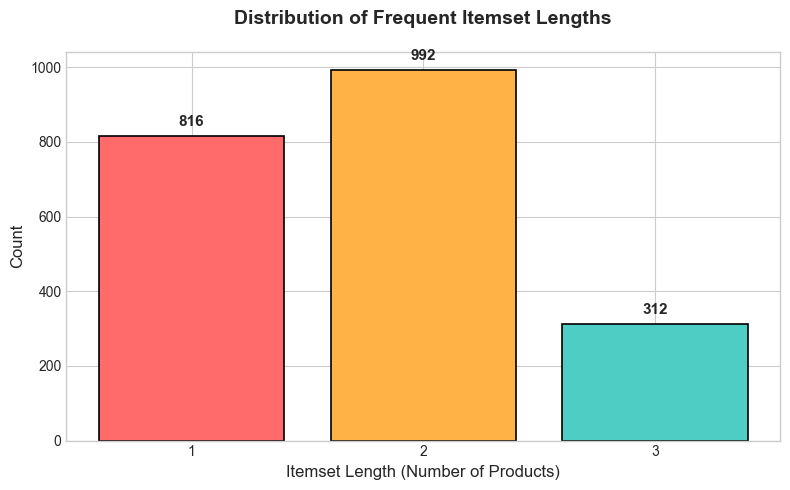

Da luu: ../images/Req1_ItemsetLengthDistribution.png


In [19]:
# =============================================================================
# TRỰC QUAN HÓA KẾT QUẢ LUẬT KẾT HỢP
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Thiết lập style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("bright")

# Tạo thư mục images nếu chưa có
import os
IMAGES_DIR = "../images"
os.makedirs(IMAGES_DIR, exist_ok=True)

print("=" * 80)
print("TRỰC QUAN HÓA KẾT QUẢ LUẬT KẾT HỢP")
print("=" * 80)

# -------------------------------------------------------------------------
# BIỂU ĐỒ 1: Phân phối độ dài Itemset (Frequent Itemsets)
# -------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 5))

itemset_lengths = frequent_itemsets['itemsets'].apply(len).value_counts().sort_index()

colors_gradient = ['#FF6B6B', '#FFB347', '#4ECDC4'][:len(itemset_lengths)]
bars = ax.bar(itemset_lengths.index, itemset_lengths.values, color=colors_gradient, edgecolor='black', linewidth=1.2)

# Thêm giá trị trên cột
for bar, value in zip(bars, itemset_lengths.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
            f'{value:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_xlabel('Itemset Length (Number of Products)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of Frequent Itemset Lengths', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(itemset_lengths.index)

plt.tight_layout()
plt.savefig(f"{IMAGES_DIR}/Req1_ItemsetLengthDistribution.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Da luu: {IMAGES_DIR}/Req1_ItemsetLengthDistribution.png")

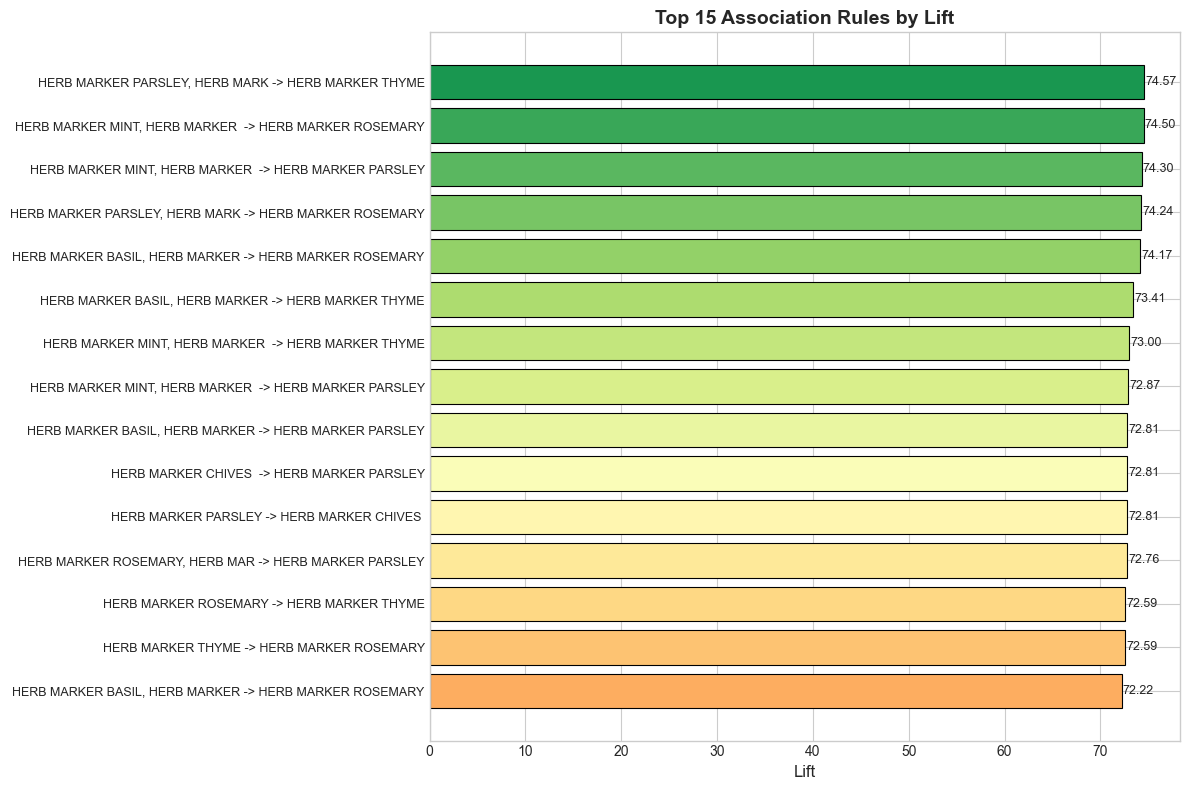

Da luu: ../images/Req1_Top15RulesByLift.png


In [20]:
# -------------------------------------------------------------------------
# BIỂU ĐỒ 2: Top 15 luật theo Lift (Bar Chart)
# -------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 8))

top_15_lift = rules_filtered.sort_values('lift', ascending=False).head(15).copy()
top_15_lift['rule_short'] = top_15_lift['antecedents_str'].str[:30] + ' -> ' + top_15_lift['consequents_str'].str[:30]

# Đảo ngược để luật cao nhất ở trên
top_15_lift = top_15_lift.iloc[::-1]

colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(top_15_lift)))
bars = ax.barh(range(len(top_15_lift)), top_15_lift['lift'], color=colors, edgecolor='black', linewidth=0.8)

ax.set_yticks(range(len(top_15_lift)))
ax.set_yticklabels(top_15_lift['rule_short'], fontsize=9)
ax.set_xlabel('Lift', fontsize=12)
ax.set_title('Top 15 Association Rules by Lift', fontsize=14, fontweight='bold')

# Thêm giá trị
for i, (bar, value) in enumerate(zip(bars, top_15_lift['lift'])):
    ax.text(value + 0.1, bar.get_y() + bar.get_height()/2, 
            f'{value:.2f}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(f"{IMAGES_DIR}/Req1_Top15RulesByLift.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Da luu: {IMAGES_DIR}/Req1_Top15RulesByLift.png")

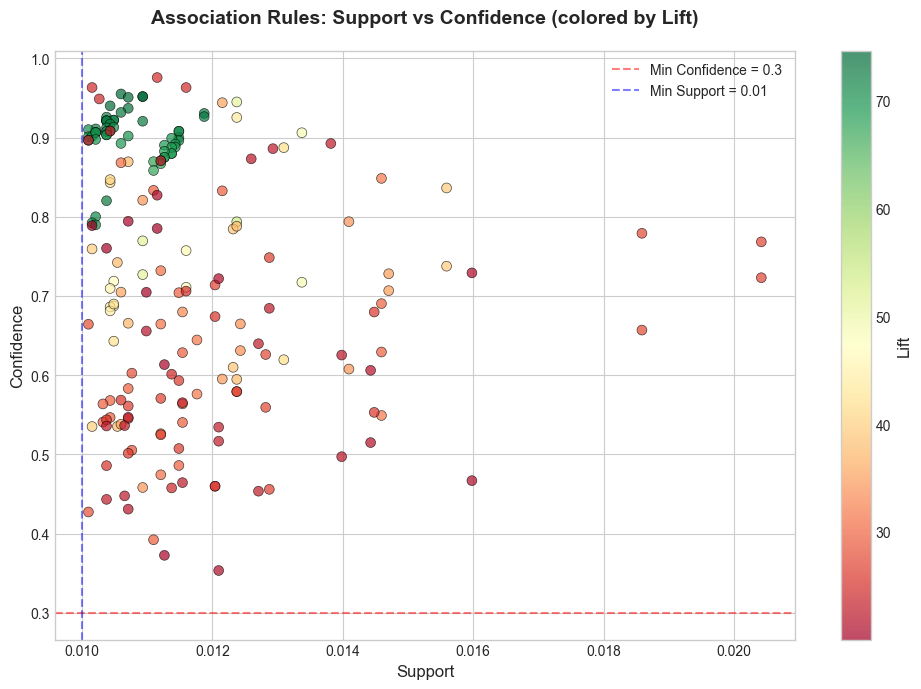

Da luu: ../images/Req1_SupportConfidenceScatter.png


In [21]:
# -------------------------------------------------------------------------
# BIỂU ĐỒ 3: Scatter Plot - Support vs Confidence (màu theo Lift)
# -------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 7))

scatter = ax.scatter(
    rules_filtered['support'], 
    rules_filtered['confidence'],
    c=rules_filtered['lift'],
    cmap='RdYlGn',
    s=50,
    alpha=0.7,
    edgecolors='black',
    linewidth=0.5
)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Lift', fontsize=12)

ax.set_xlabel('Support', fontsize=12)
ax.set_ylabel('Confidence', fontsize=12)
ax.set_title('Association Rules: Support vs Confidence (colored by Lift)', fontsize=14, fontweight='bold', pad=20)

# Thêm đường tham chiếu với biến FINAL_*
ax.axhline(y=FINAL_MIN_CONFIDENCE, color='red', linestyle='--', alpha=0.5, label=f'Min Confidence = {FINAL_MIN_CONFIDENCE}')
ax.axvline(x=FINAL_MIN_SUPPORT, color='blue', linestyle='--', alpha=0.5, label=f'Min Support = {FINAL_MIN_SUPPORT}')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig(f"{IMAGES_DIR}/Req1_SupportConfidenceScatter.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Da luu: {IMAGES_DIR}/Req1_SupportConfidenceScatter.png")

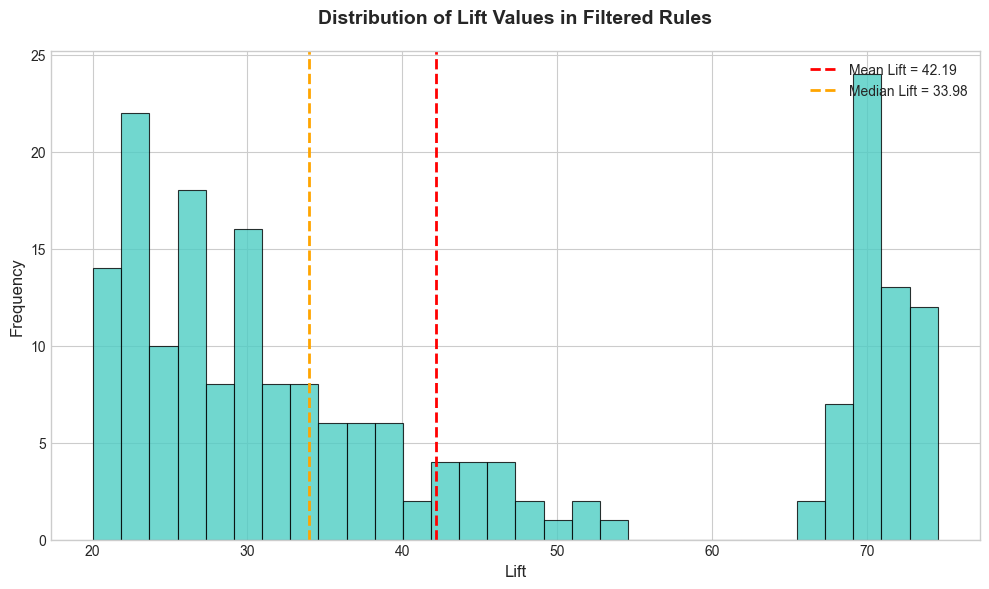

Da luu: ../images/Req1_LiftDistribution.png


In [22]:
# -------------------------------------------------------------------------
# BIỂU ĐỒ 4: Phân phối Lift của các luật đã lọc (Histogram)
# -------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(rules_filtered['lift'], bins=30, color='#4ECDC4', edgecolor='black', linewidth=0.8, alpha=0.8)

ax.axvline(x=rules_filtered['lift'].mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean Lift = {rules_filtered["lift"].mean():.2f}')
ax.axvline(x=rules_filtered['lift'].median(), color='orange', linestyle='--', linewidth=2, 
           label=f'Median Lift = {rules_filtered["lift"].median():.2f}')

ax.set_xlabel('Lift', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Lift Values in Filtered Rules', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig(f"{IMAGES_DIR}/Req1_LiftDistribution.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Da luu: {IMAGES_DIR}/Req1_LiftDistribution.png")

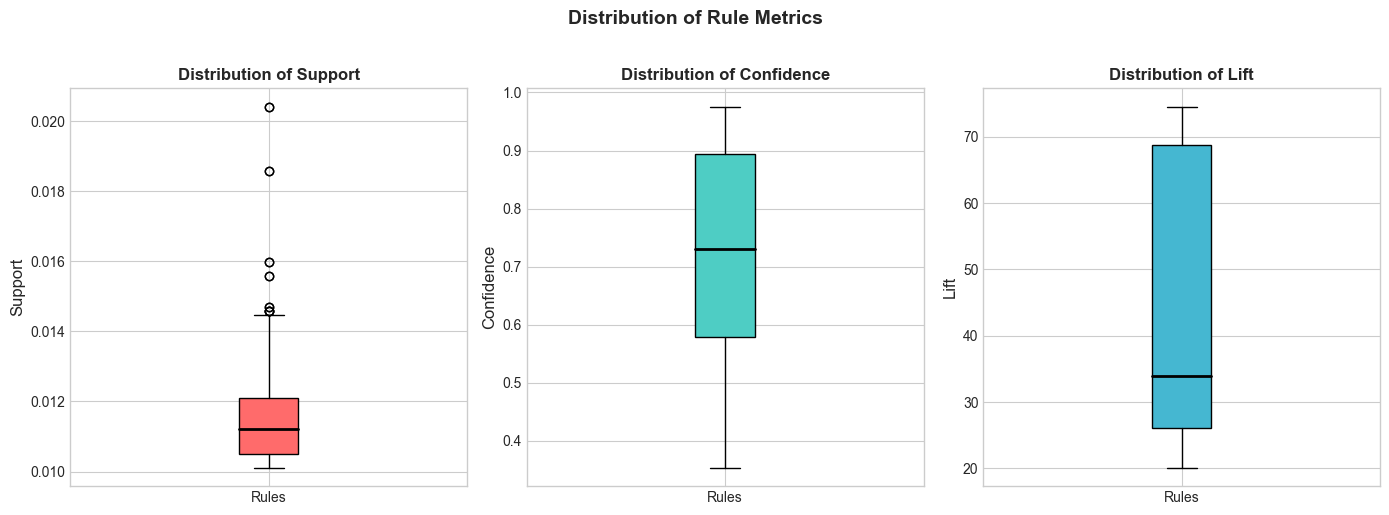

Da luu: ../images/Req1_MetricsDistribution.png


In [23]:
# -------------------------------------------------------------------------
# BIỂU ĐỒ 5: Phân phối Support, Confidence của luật (Boxplot)
# -------------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# Boxplot Support
axes[0].boxplot(rules_filtered['support'], patch_artist=True,
                boxprops=dict(facecolor='#FF6B6B', color='black'),
                medianprops=dict(color='black', linewidth=2))
axes[0].set_ylabel('Support', fontsize=12)
axes[0].set_title('Distribution of Support', fontsize=12, fontweight='bold')
axes[0].set_xticklabels(['Rules'])

# Boxplot Confidence  
axes[1].boxplot(rules_filtered['confidence'], patch_artist=True,
                boxprops=dict(facecolor='#4ECDC4', color='black'),
                medianprops=dict(color='black', linewidth=2))
axes[1].set_ylabel('Confidence', fontsize=12)
axes[1].set_title('Distribution of Confidence', fontsize=12, fontweight='bold')
axes[1].set_xticklabels(['Rules'])

# Boxplot Lift
axes[2].boxplot(rules_filtered['lift'], patch_artist=True,
                boxprops=dict(facecolor='#45B7D1', color='black'),
                medianprops=dict(color='black', linewidth=2))
axes[2].set_ylabel('Lift', fontsize=12)
axes[2].set_title('Distribution of Lift', fontsize=12, fontweight='bold')
axes[2].set_xticklabels(['Rules'])

plt.suptitle('Distribution of Rule Metrics', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f"{IMAGES_DIR}/Req1_MetricsDistribution.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Da luu: {IMAGES_DIR}/Req1_MetricsDistribution.png")

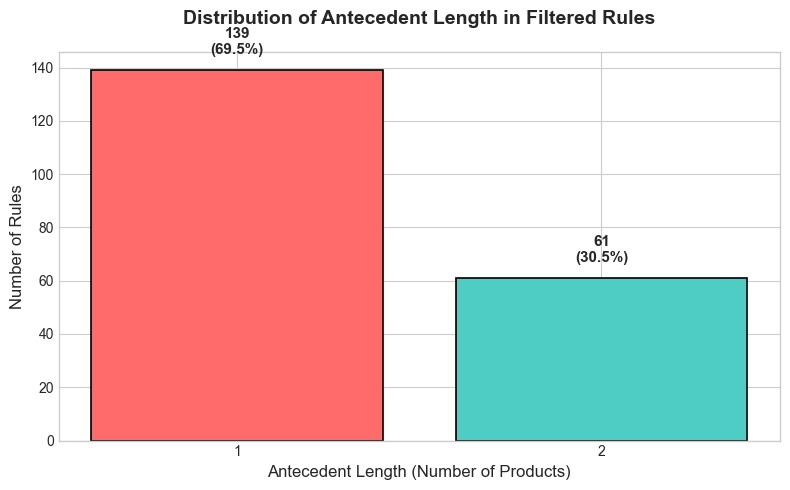

Da luu: ../images/Req1_AntecedentLengthDistribution.png

HOAN THANH TRUC QUAN HOA YEU CAU 1

Da luu tong cong 6 bieu do vao thu muc: ../images


In [24]:
# -------------------------------------------------------------------------
# BIỂU ĐỒ 6: Phân phối độ dài Antecedent trong luật đã lọc
# -------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 5))

ant_len_dist = rules_filtered['antecedents'].apply(len).value_counts().sort_index()

colors = ['#FF6B6B', '#4ECDC4'][:len(ant_len_dist)]
bars = ax.bar(ant_len_dist.index, ant_len_dist.values, color=colors, edgecolor='black', linewidth=1.2)

# Thêm giá trị và phần trăm
total = ant_len_dist.sum()
for bar, value in zip(bars, ant_len_dist.values):
    pct = value / total * 100
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
            f'{value:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_xlabel('Antecedent Length (Number of Products)', fontsize=12)
ax.set_ylabel('Number of Rules', fontsize=12)
ax.set_title('Distribution of Antecedent Length in Filtered Rules', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(ant_len_dist.index)

plt.tight_layout()
plt.savefig(f"{IMAGES_DIR}/Req1_AntecedentLengthDistribution.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Da luu: {IMAGES_DIR}/Req1_AntecedentLengthDistribution.png")

print("\n" + "=" * 80)
print("HOAN THANH TRUC QUAN HOA YEU CAU 1")
print("=" * 80)
print(f"\nDa luu tong cong 6 bieu do vao thu muc: {IMAGES_DIR}")